In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../src/")
import utils as ut
import integration as itg
import mittag_leffler as ml
from fLe_twobath import fle_twobath
import plot_utils as pu

plt.style.use("plot_style.mplstyle")

data_path = "../data/two_baths/"

In [2]:
def first_guess(t, noise, order, v0):
    t__ = np.array(t)
    noise__ = np.array(noise)
    def nonlinear_term(t):
        z = -t**(2-order)
        return t * ml.mittag_leffler(z, 2-order, 2)
    conv = itg.convolution(nonlinear_term, noise__, t__)
    nonlinear = v0 * nonlinear_term(t__)
    return nonlinear + conv

In [3]:
# Next-guess algorithm
def inspect_nga(H, N, id):
    return ut.read_hdf5_data(f"{data_path}two_baths-h-{H}-{N}-{id}.hdf5")

In [4]:
# Finite differences
def inspect_fd(H, N, T, id):
    path_H = (f"{data_path}fBM-h-{H}-{N}-{id}.hdf5")
    path_12 = (f"{data_path}fBM-h-0.5-{N}-{id}.hdf5")
    noise_path = (f"{data_path}two_baths-h-{H}-noise{N}-{id}.hdf5")
    
    BH = ut.read_hdf5_data(path_H)
    B12 = ut.read_hdf5_data(path_12)
    B = np.array(BH.deets_v) + np.array(B12.deets_v)
    
    dBH = ut.read_hdf5_data(noise_path)
    
    t = dBH.deets_t
    
    delta_t = T/N
    
    eq = fle_twobath(H)
    eq.params(T, h = delta_t, v0 = 0)#first_guess_[2]/delta_t)
    eq.external_B(B, t)
    eq.solve()
    eq.get_analytical(relaxation_type = 1)
    
    return eq

In [5]:
def plot_comparison(H, N, T, id, ax, panel, xlabel = False, ylabel = False):
    nga = inspect_nga(H, N, id)
    eq = inspect_fd(H, N, T, id)

    ax.plot(nga.deets_t, nga.deets_v, ls = "-", label = "Next-guess algorithm")
    ax.plot(eq.t, eq.numerical, label = "Finite differences")
    ax.plot(eq.t, eq.analytical, ls = "--", label = "Analytical")
    ax.set_title(f"H = {H}")
    if ylabel:
        ax.set_ylabel(r"$q(t)$")
    if xlabel:
        ax.set_xlabel(r"$t$")
    pu.add_caption_letter(ax, panel)

0.6
0.8
0.9
0.99


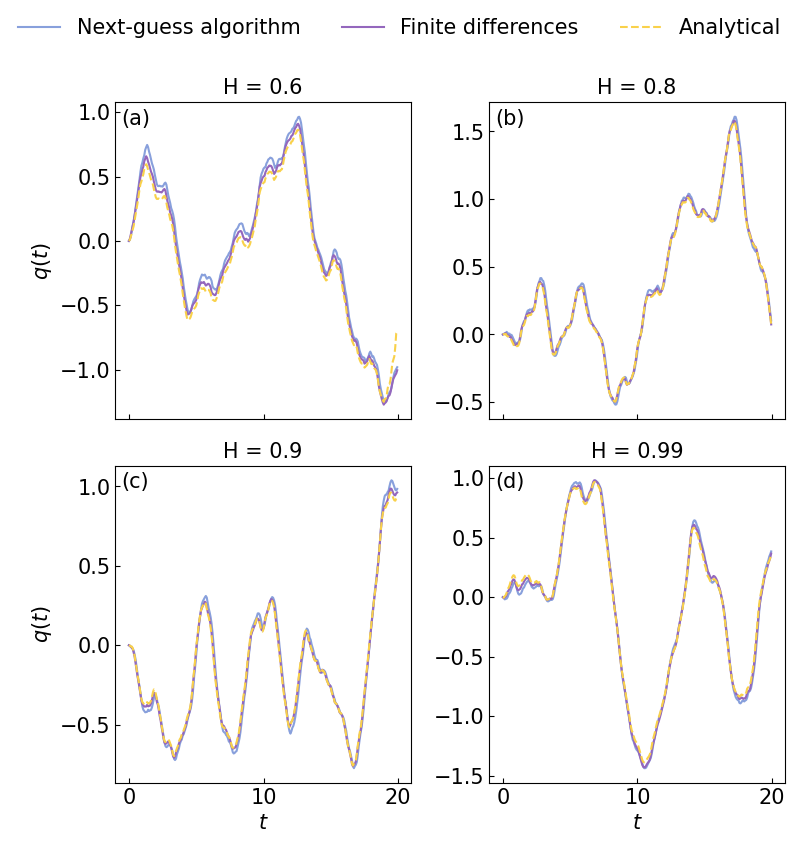

In [6]:
T = 20
fig, ax = plt.subplots(2,2, figsize=(8,8), sharex = True)

H = 0.6
N = 280
T = 20
id = 2
print(H)
plot_comparison(H, N, T, id, ax[0][0], "(a)", ylabel = True)

H = 0.8
N = 280
T = 20
id = 4
print(H)
plot_comparison(H, N, T, id, ax[0][1], "(b)")

H = 0.9
N = 280
T = 20
id = 5
print(H)
plot_comparison(H, N, T, id, ax[1][0], "(c)", xlabel = True, ylabel = True)

H = 0.99
N = 280
T = 20
id = 6
print(H)
plot_comparison(H, N, T, id, ax[1][1], "(d)", xlabel = True)

handles, labels = ax[1][1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = (0.99, 1.07), ncol = 3)

In [7]:
fig.savefig("../outs/solutions_all_200dpi.png", dpi = 200)
fig.savefig("../outs/solutions_all_500dpi.png", dpi = 500)
fig.savefig("../outs/solutions_all_1000dpi.png", dpi = 1000)